In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pylab import rcParams
import re
import time
from datetime import datetime
import seaborn as sns

%matplotlib inline

In [38]:
df = pd.read_csv("readings.csv", on_bad_lines='error')[["load_avg", "cpu_pct", "cpu_speed", "volts", "temp"]]
display(df.shape, df.head())

(2500, 5)

,load_avg,cpu_pct,cpu_speed,volts,temp
0,0.577148,5.1,1.500013,0.7200,46.6
1,0.577148,23.3,2.400024,0.8806,46.6
2,0.577148,1.9,2.400020,0.8806,47.2
3,0.577148,1.9,2.400020,0.8806,47.2
4,0.577148,1.0,2.400030,0.8806,46.6


<Figure size 640x480 with 0 Axes>

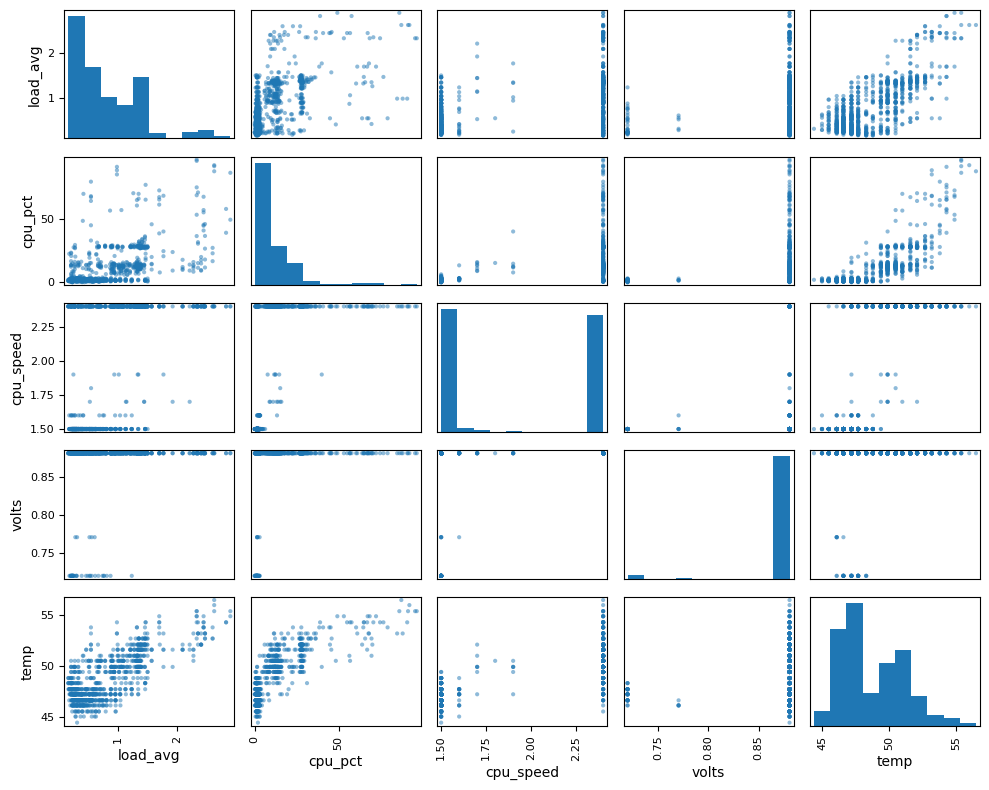

In [39]:
plt.clf()
if len(df) > 1000:
    scatter_matrix(df.sample(1000), figsize=(10, 8))
plt.tight_layout() 
plt.show()

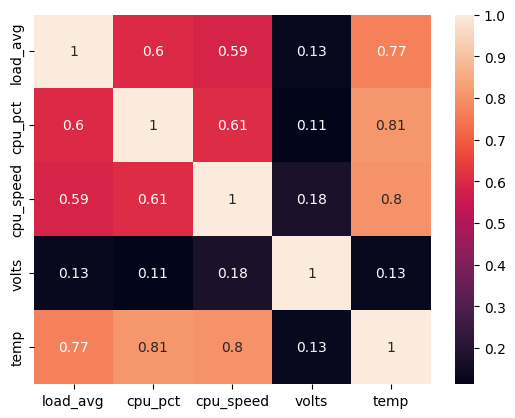

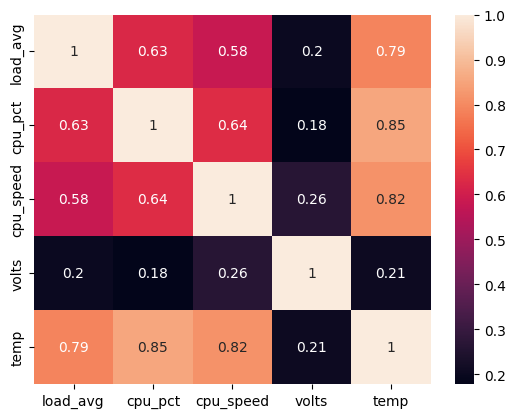

In [40]:
# 5-point rolling average to smooth noise
df_adjusted = df.copy()
rolling_cols = ["volts", "load_avg", "temp", "cpu_pct"]
df_adjusted[rolling_cols] = df_adjusted[rolling_cols].rolling(window=5).mean()

sns.heatmap(df.corr(), annot=True)
plt.show()
sns.heatmap(df_adjusted.corr(), annot=True)
plt.show()

# Basic Linear Regression
Predicting CPU temperature from metrics using linear models.

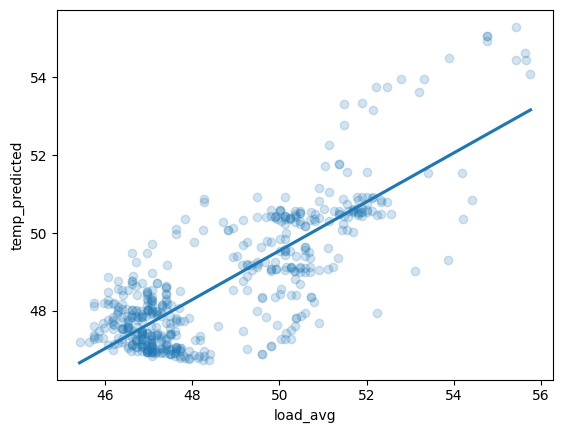

'Model coefficients: [1.75224504]'

'Model intercept: 48.744188376753506'

'Mean squared error: 1.65'

'Coefficient of determination: 0.65'

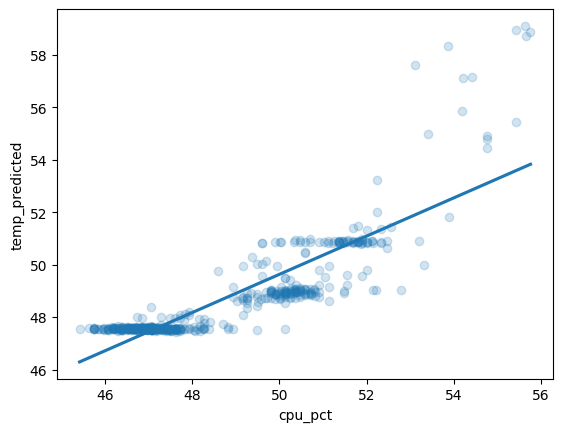

'Model coefficients: [1.90288126]'

'Model intercept: 48.744188376753506'

'Mean squared error: 1.27'

'Coefficient of determination: 0.73'

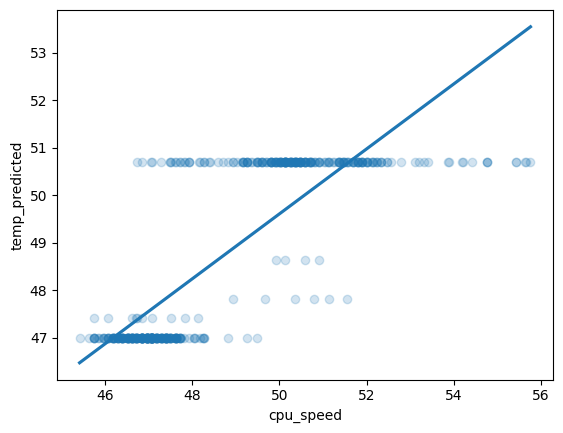

'Model coefficients: [1.8180566]'

'Model intercept: 48.744188376753506'

'Mean squared error: 1.56'

'Coefficient of determination: 0.67'

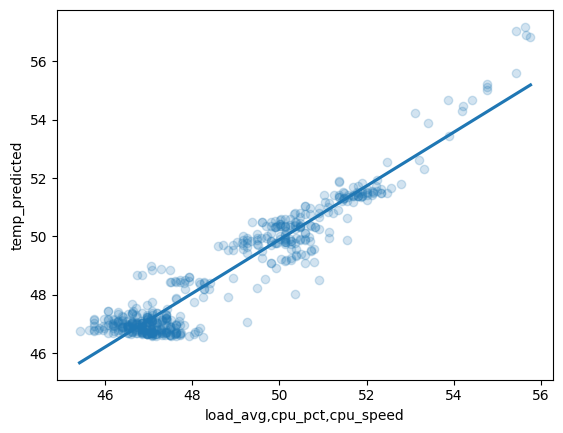

'Model coefficients: [0.69660479 0.96288498 0.80059952]'

'Model intercept: 48.744188376753506'

'Mean squared error: 0.43'

'Coefficient of determination: 0.91'

In [59]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Grab the adjusted data, but drop any rows with missing data.
# The rows with missing data were created by the rolling average.
df_data = df_adjusted.dropna(how="any")

# Try it first with each column, then with all. We know from the histograms
# that volts is probably useless as a predictor!
linreg_feature_cols = ["load_avg", "cpu_pct", "cpu_speed"]
for fc in [[x] for x in linreg_feature_cols] + [linreg_feature_cols]:

    # Separate the feature data from the target data we want to predict.
    X = df_data[fc]
    y = df_data.temp

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    plt.clf()

    linreg = make_pipeline(StandardScaler(), 
                           LinearRegression()) 
    linreg.fit(X_train,y_train)
    y_pred = linreg.predict(X_test)

    sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws={'alpha':0.2})
    plt.xlabel(",".join(fc))
    plt.ylabel('temp_predicted')
    plt.show()
    # Show some model stats
    regression_model = linreg.named_steps['linearregression']
    display(f"Model coefficients: {regression_model.coef_}")
    display(f"Model intercept: {regression_model.intercept_}")

    # We want a low mean squared error and a coefficient of determination (R^2) as close to 1 as possible.
    display(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
    display(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

# Basic Logistic Regression

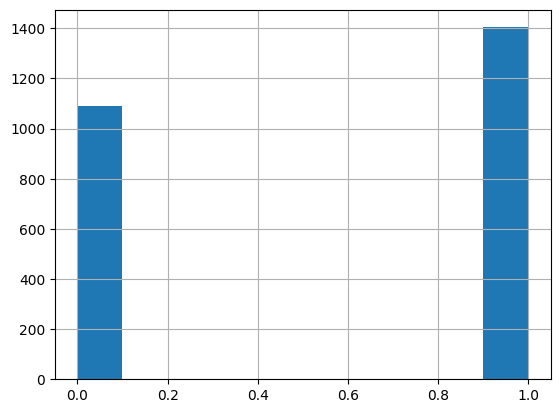

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp,fan_state
cpu_speed,1.000000,0.266795,0.727922,0.650388,0.614881,0.824529,0.728694
volts,0.266795,1.000000,0.073997,0.178357,0.201503,0.205284,0.067758
fan_speed,0.727922,0.073997,1.000000,0.506010,0.655393,0.645568,0.991132
cpu_pct,0.650388,0.178357,0.506010,1.000000,0.644502,0.836964,0.509066
load_avg,0.614881,0.201503,0.655393,0.644502,1.000000,0.766699,0.638073
temp,0.824529,0.205284,0.645568,0.836964,0.766699,1.000000,0.642958
fan_state,0.728694,0.067758,0.991132,0.509066,0.638073,0.642958,1.000000


'Train length: 1996, Test length: 500'

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       229
           1       0.92      0.85      0.88       271

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



array([[210,  19],
       [ 41, 230]])

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df_data = df_adjusted.copy().dropna(how="any")

# Convert fan speed into an on/off indicator.
df_data["fan_state"] = df_data.fan_speed.apply(lambda x: 1 if x > 0 else 0)
plt.clf()
df_data.fan_state.hist()
plt.show()

display(df_data.corr())

# logreg_feature_cols = ["volts", "cpu_pct", "load_avg", "cpu_speed", "temp"] # NOT fan speed!
logreg_feature_cols = ["load_avg", "temp"] # NOT fan speed!

X = df_data[logreg_feature_cols].values
y = df_data.fan_state.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

logreg = make_pipeline(StandardScaler(), 
                       LogisticRegression()) 
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
display(metrics.confusion_matrix(y_test, y_pred))

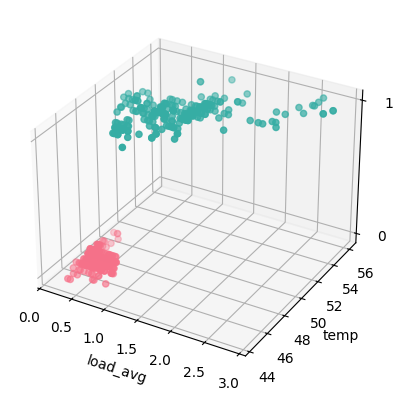

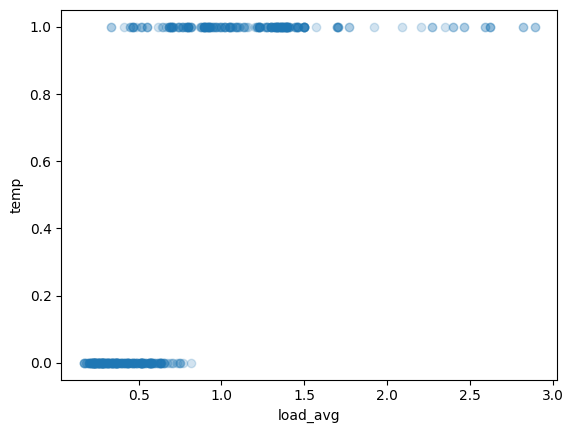

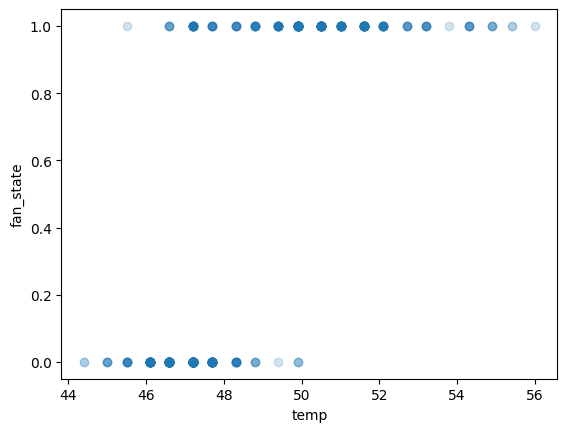

In [7]:
from matplotlib.colors import ListedColormap

plt.clf()

ax = plt.axes(projection = '3d')

x = np.array(X_test).T[0]
y = np.array(X_test).T[1]
z = y_pred

ax.set_xlabel("load_avg")
ax.set_ylabel("temp")
ax.set_zlabel("fan_state")
ax.set_zticks([0,1])

cmap = ListedColormap(sns.color_palette("husl", 2).as_hex())
ax.scatter(x, y, z, c=z, cmap=cmap)

plt.show()

plt.clf()
ax = plt.axes()
ax.scatter(np.array(X_test).T[0], y_pred, alpha=0.2)
plt.xlabel('load_avg')
plt.ylabel('temp')
plt.show()

plt.clf()
ax = plt.axes()
ax.scatter(np.array(X_test).T[1], y_pred, alpha=0.2)
plt.xlabel('temp')
plt.ylabel('fan_state')
plt.show()


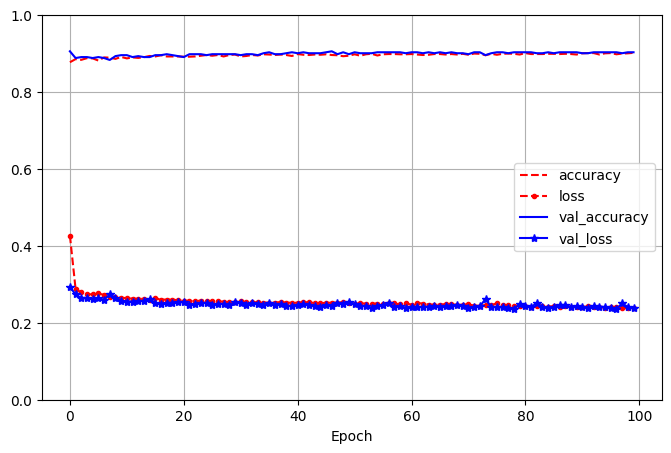

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9160 - loss: 0.2260 


[0.24077677726745605, 0.906000018119812]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


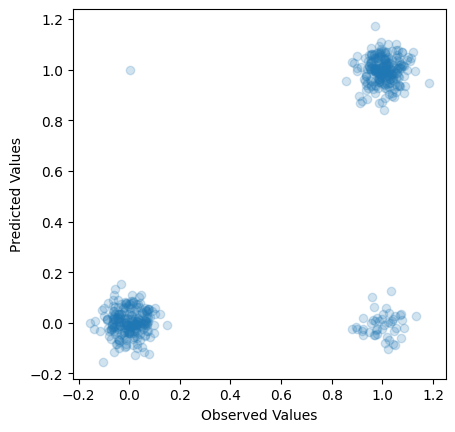

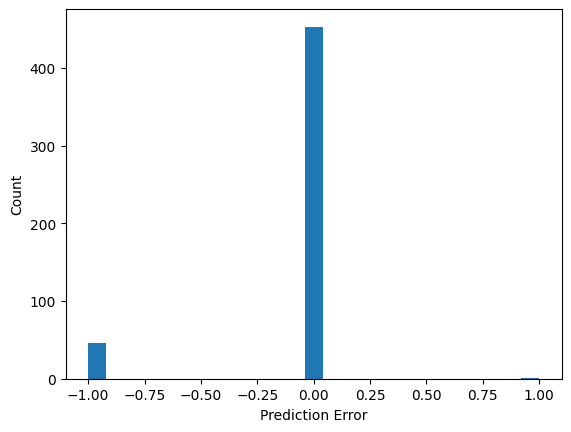